In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18284644022041852989
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9377415168
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18073772378302361023
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1


# Sentiment Analysis Using Simple & Complex (CNN + LSTM)

**Architecture**\

Dataset -> Preprocessing -> Word Embedding -> Model Training -> Predictions

In [2]:
# Importing Libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.models import load_model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Exploring Data

In [3]:
# Loading Dataset
movie_rev = pd.read_csv("a1_IMDB_Dataset.csv")

In [4]:
# Eploring Data
movie_rev.shape

(50000, 2)

In [5]:
movie_rev.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [6]:
movie_rev.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

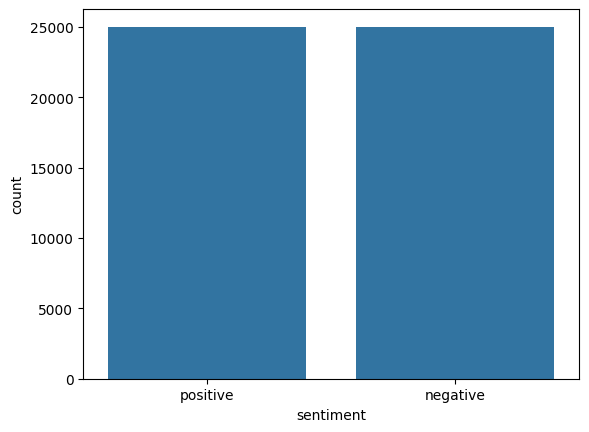

In [7]:
sns.countplot(x='sentiment', data=movie_rev)

## Data Preprocessing

In [8]:
movie_rev['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

The reviews consists of puntuations, brackets, html tags and more so the data needs to be pre-processed for further methodology

In [9]:
tag_re = re.compile(r'<[^>]+>')
def remove_tg(text):
    '''
    Removes tags and replaces anything that is present between < and > with empty spaces
    '''
    return tag_re.sub('', text)

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def preprocess_txt(sen):
    '''
    cleans text data, leaves only those non-stop words that are of A-Z and a-z only in lower-case
    '''
    # changing all to lowercase
    sentence = sen.lower()

    # removing html tags
    sentence = remove_tg(sentence)

    # removing punctuaions & nums
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # removing single chars
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # removing multi chars
    sentence = re.sub(r'\s+', ' ', sentence)

    # remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [12]:
# calling preprocessing function on dataset
x = []
sentences = list(movie_rev['review'])
for sen in sentences:
    x.append(preprocess_txt(sen))

In [13]:
# Confirming cleaned up review
x[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [14]:
# converting sentiment-labels into 0's & 1's
y = movie_rev['sentiment']
y = np.array(list(map(lambda x:1 if x=='positive' else 0,y)))

## Splitting data into training and testing data

In [15]:
# Train is for learning the model and test is for evaluation of model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

## Preparation of Embedding Layer

This is to convert the textual data into numerical data which can then be used in deep learning models as first-layer in keras

In [16]:
# embedding layer needs words to be in number form
# making use of tokenizer function from keras.preprocessing.text lib
# the fit_on_text trains the tokenizer
# text_to_sequences converts the sentences to their respective numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

x_train = word_tokenizer.texts_to_sequences(x_train)
x_test = word_tokenizer.texts_to_sequences(x_test)

In [17]:
# addition of 1 to store the dimensions for words for thich there are no pretrained embeddings
voc_len = len(word_tokenizer.word_index) + 1
print(voc_len)

92394


In [18]:
# Applying padding to all the reviews to fixed len of 100
max_len = 100
x_train = pad_sequences(x_train, padding='post', maxlen = max_len)
x_test = pad_sequences(x_test, padding='post', maxlen = max_len)

In [19]:
# Making use of GloVe words embedding and creating dict
from numpy import asarray
from numpy import zeros

emb_dict = dict()
glove_fl = open('a2_glove.6B.100d.txt', encoding='utf8')

for line in glove_fl:
    rec = line.split()
    word = rec[0]
    vec_dims = asarray(rec[1:], dtype='float32')
    emb_dict[word] = vec_dims
glove_fl.close

<function TextIOWrapper.close()>

In [20]:
# making embedding-mat with 100-colsL
# comprising 100-dim glove word embeds for every word

emb_mat = zeros((voc_len, 100))
for word, index in word_tokenizer.word_index.items():
    emb_vec = emb_dict.get(word)
    if emb_vec is not None:
        emb_mat[index] = emb_vec

In [21]:
# shape of emb_mat
emb_mat.shape

(92394, 100)

## Simple_Neural_Network

In [22]:
nn = Sequential()
emb_layer = Embedding(voc_len, 100, weights=[emb_mat], input_length=max_len,trainable=False)
nn.add(emb_layer)
nn.add(Flatten())
nn.add(Dense(1,activation='sigmoid'))

In [23]:
# Compilation
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,249,401
Trainable params: 10,001
Non-trainable params: 9,239,400
_________________________________________________________________


In [24]:
# Training the model
# batch of 128 should be good since 64 can lead to overfitting and anything more than 128 can lead to underfitting
nn_model = nn.fit(x_train, y_train, batch_size=128,epochs=10,verbose=1,validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.5618 - acc: 0.7133 - val_loss: 0.5058 - val_acc: 0.7629
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4489 - acc: 0.7951 - val_loss: 0.4984 - val_acc: 0.7655
Epoch 3/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4142 - acc: 0.8171 - val_loss: 0.5026 - val_acc: 0.7638
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3898 - acc: 0.8293 - val_loss: 0.5266 - val_acc: 0.7567
Epoch 5/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3764 - acc: 0.8368 - val_loss: 0.5209 - val_acc: 0.7600
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3629 - acc: 0.8430 - val_loss: 0.5339 - val_acc: 0.7585
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3540 - acc: 0.8450 - val_loss: 0.5553 - val_acc: 0.7498
Epoch 8/10
250/250 [==============================] - 0s 2ms/step - loss: 0.

In [25]:
# Performance of Model
score = nn.evaluate(x_test, y_test, verbose=1)

print("Test_Score : ", score[0]*100)
print("Test_Accuracy : ", score[1]*100)       

313/313 [==============================] - 0s 1ms/step - loss: 0.6074 - acc: 0.7420
Test_Score :  60.740941762924194
Test_Accuracy :  74.19999837875366


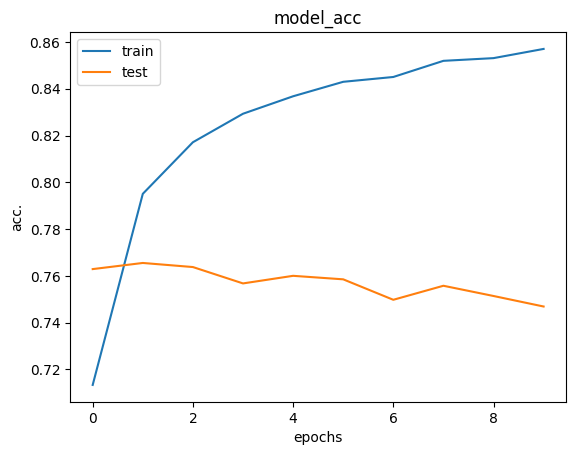

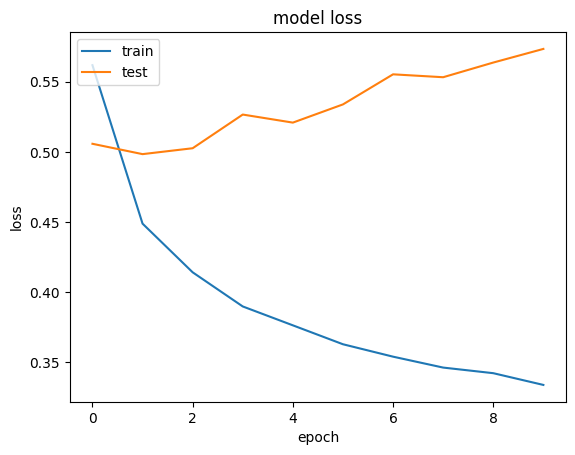

In [26]:
# Performance graphical representation

plt.plot(nn_model.history['acc'])
plt.plot(nn_model.history['val_acc'])

plt.title('model_acc')
plt.ylabel('acc.')
plt.xlabel('epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(nn_model.history['loss'])
plt.plot(nn_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## CNN - Convolutional-Neural-Networks

In [27]:
cnn = Sequential()
emb_layer = Embedding(voc_len, 100, weights=[emb_mat], input_length = max_len, trainable=False)
cnn.add(emb_layer)
cnn.add(Conv1D(128,5,activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(1,activation='sigmoid'))

In [28]:
# Compiling the cnn-model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________


In [29]:
# Training the cnn-model
cnn_model = cnn.fit(x_train,y_train, batch_size=128, epochs=10,verbose=1,validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 3s 3ms/step - loss: 0.4779 - acc: 0.7688 - val_loss: 0.3762 - val_acc: 0.8364
Epoch 2/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3409 - acc: 0.8551 - val_loss: 0.3453 - val_acc: 0.8505
Epoch 3/10
250/250 [==============================] - 1s 2ms/step - loss: 0.2856 - acc: 0.8856 - val_loss: 0.3334 - val_acc: 0.8534
Epoch 4/10
250/250 [==============================] - 1s 2ms/step - loss: 0.2436 - acc: 0.9085 - val_loss: 0.3324 - val_acc: 0.8530
Epoch 5/10
250/250 [==============================] - 1s 2ms/step - loss: 0.2021 - acc: 0.9320 - val_loss: 0.3275 - val_acc: 0.8568
Epoch 6/10
250/250 [==============================] - 1s 2ms/step - loss: 0.1672 - acc: 0.9506 - val_loss: 0.3328 - val_acc: 0.8558
Epoch 7/10
250/250 [==============================] - 1s 2ms/step - loss: 0.1343 - acc: 0.9674 - val_loss: 0.3373 - val_acc: 0.8559
Epoch 8/10
250/250 [==============================] - 1s 2ms/step - loss: 0.

In [30]:
# Making predictions on the test data
score = cnn.evaluate(x_test, y_test, verbose=1)
print('test_score : ', score[0]*100)
print('test_acc : ', score[1]*100)

313/313 [==============================] - 1s 1ms/step - loss: 0.3728 - acc: 0.8501
test_score :  37.284451723098755
test_acc :  85.00999808311462


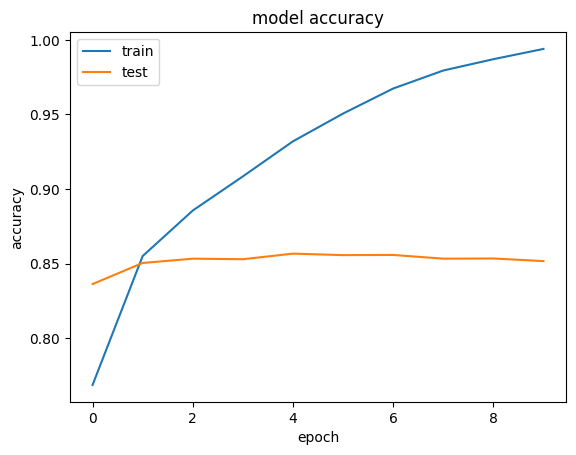

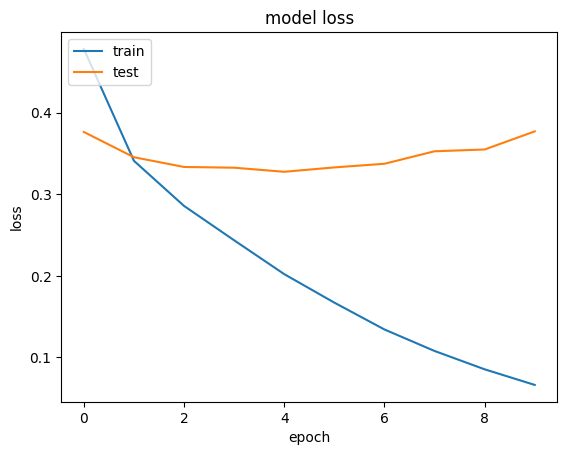

In [31]:
# Making performance-charts

plt.plot(cnn_model.history['acc'])
plt.plot(cnn_model.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## LSTM (Recurrent-Neural-Networks)

In [32]:
# Architecture
lstm = Sequential()
emb_layer = Embedding(voc_len,100,weights=[emb_mat],input_length=max_len,trainable=False)
lstm.add(emb_layer)
lstm.add(LSTM(128))
lstm.add(Dense(1,activation='sigmoid'))

In [33]:
# Compiling the model
lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________


In [34]:
# Training the model
lstm_model = lstm.fit(x_train,y_train,batch_size=128,epochs=10,verbose=1,validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 5s 13ms/step - loss: 0.5585 - acc: 0.7185 - val_loss: 0.4680 - val_acc: 0.7936
Epoch 2/10
250/250 [==============================] - 3s 12ms/step - loss: 0.4267 - acc: 0.8088 - val_loss: 0.4199 - val_acc: 0.8130
Epoch 3/10
250/250 [==============================] - 3s 12ms/step - loss: 0.3787 - acc: 0.8345 - val_loss: 0.3628 - val_acc: 0.8441
Epoch 4/10
250/250 [==============================] - 3s 14ms/step - loss: 0.3521 - acc: 0.8528 - val_loss: 0.3387 - val_acc: 0.8560
Epoch 5/10
250/250 [==============================] - 3s 12ms/step - loss: 0.3256 - acc: 0.8609 - val_loss: 0.3174 - val_acc: 0.8649
Epoch 6/10
250/250 [==============================] - 3s 14ms/step - loss: 0.3047 - acc: 0.8714 - val_loss: 0.3211 - val_acc: 0.8708
Epoch 7/10
250/250 [==============================] - 3s 13ms/step - loss: 0.2910 - acc: 0.8802 - val_loss: 0.3047 - val_acc: 0.8700
Epoch 8/10
250/250 [==============================] - 3s 13ms/step - 

In [35]:
# Making predictions
score = lstm.evaluate(x_test,y_test,verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 0.3241 - acc: 0.8588


In [36]:
# Performance of model
print('test_score : ',score[0]*100)
print('test_acc : ',score[1]*100)

test_score :  32.40513503551483
test_acc :  85.87999939918518


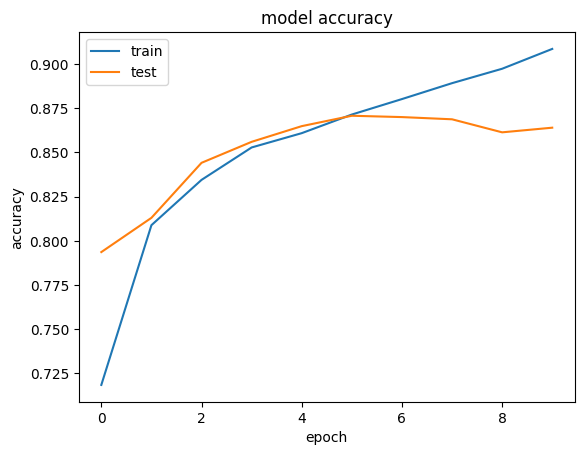

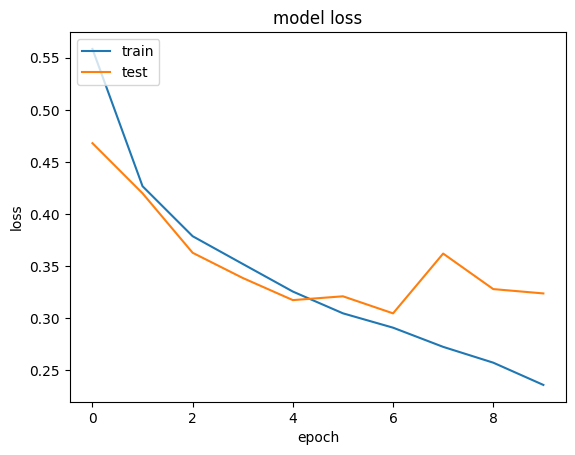

In [37]:
# Performance graphical representation

plt.plot(lstm_model.history['acc'])
plt.plot(lstm_model.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model.history['loss'])
plt.plot(lstm_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [38]:
# Saving lstm model for later usage
lstm.save(f'lstm_model_{round(score[1],3)*100}.h5',save_format='h5')

## Live-Predictions-IMDB-Data

In [39]:
# To load previous trained model file

# model_path ='lstm_model_86.1.h5'
# pretrained_lstm = load_model(model_path)

# pretrained_lstm.summary()

In [40]:
sample_revs = pd.read_csv('a3_IMDb_Unseen_Reviews.csv')
sample_revs.head(5)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10


In [41]:
# Preprocessing the review text with the pre-defined function (preprocess_txt)
new_revs = sample_revs['Review Text']
new_processed = []
for rev in new_revs:
    rev = preprocess_txt(rev)
    new_processed.append(rev)

In [42]:
# Tokenized isntance for our pre-trained tokenizer
new_token = word_tokenizer.texts_to_sequences(new_processed)
new_padded = pad_sequences(new_token, padding='post', maxlen=max_len)

In [43]:
# tokenized instance is passed below to the lstm for making predictions
new_sentiments = lstm.predict(new_padded)
new_sentiments

1/1 [==============================] - 0s 281ms/step


array([[0.97806704],
       [0.9991177 ],
       [0.15234978],
       [0.29556116],
       [0.97201   ],
       [0.00809975]], dtype=float32)

In [44]:
# Writing/Saving the model predictions
sample_revs['predicted_sentiments'] = np.round(new_sentiments*10,1)

df_pred_sentiments = pd.DataFrame(sample_revs['predicted_sentiments'], columns = ['predicted_sentiments'])
df_movies = pd.DataFrame(sample_revs['Movie'], columns = ['Movie'])
df_rev_txt = pd.DataFrame(sample_revs['Review Text'], columns = ['Review Text'])
df_imdb_rat = pd.DataFrame(sample_revs['IMDb Rating'], columns = ['IMDb Rating'])

dfx = pd.concat([df_movies, df_rev_txt, df_imdb_rat, df_pred_sentiments], axis=1)
dfx.to_csv('./imdb_new_predictions.csv', sep=',', encoding = 'UTF-8')

dfx.head(5)

,Movie,Review Text,IMDb Rating,predicted_sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,10.0
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.5
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,3.0
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
